Physics-first planet classifier:

1. Purpose: decide if a transit signal is physically consistent with a planet, independent of pipeline confidence. Include features that encode physics/geometry, not pipeline confidence:

2. Keep: koi_period, koi_duration, koi_depth, koi_prad, koi_slogg, koi_steff, koi_srad, derived physically motivated features you built (e.g., transit_shape_index, duty cycle, duration anomaly, transit-inferred stellar density vs catalog).

3. Drop: koi_model_snr, koi_score, koi_pdisposition, koi_fpflag_*, delivery names, any post-vetting artifacts.

4. Labels: Train on CONFIRMED vs FALSE POSITIVE only.Treat CANDIDATE as “unlabeled.” Use the trained model to score candidates after training.

5. Rationale:Depth and duration are not “telescope metadata.” They are the physical observables of the transit geometry. SNR is not; it is detection quality and pipeline-dependent. This path avoids leakage of the vetting pipeline into your model and keeps interpretability high.

6. Evaluation: Primary: PR-AUC on CONFIRMED vs FALSE POSITIVE. Secondary: calibration (reliability curve) so scores on CANDIDATE are meaningful. Sanity checks: decision rules align with physics (e.g., extreme depth + giant host → FP).

In [2]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv("koi.csv")

In [4]:
df.head(5)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [5]:
df.columns

Index(['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
       'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1',
       'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2',
       'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
       'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')

Dropping all the irrelevant columns - identifiers, light curve fit errors, etc

In [ ]:
drop_cols = [
    "kepid", "kepoi_name", "kepler_name",
    "koi_pdisposition", "koi_score", "koi_tce_delivname",
    "koi_fpflag_nt", "koi_fpflag_ss", "koi_fpflag_co", "koi_fpflag_ec",
    "koi_time0bk", 'koi_model_snr', 'koi_tce_plnt_num', 'ra', 'dec', 'koi_kepmag'
]

err_cols = [c for c in df.columns if c.endswith("_err1") or c.endswith("_err2")]

df1 = df.drop(columns = drop_cols + err_cols, errors="ignore")

In [7]:
df1.columns

Index(['koi_disposition', 'koi_period', 'koi_impact', 'koi_duration',
       'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_steff',
       'koi_slogg', 'koi_srad'],
      dtype='object')

In [8]:
df1.head(5)

,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_steff,koi_slogg,koi_srad
0,CONFIRMED,9.488036,0.146,2.95750,615.8,2.26,793.0,93.59,5455.0,4.467,0.927
1,CONFIRMED,54.418383,0.586,4.50700,874.8,2.83,443.0,9.11,5455.0,4.467,0.927
2,CANDIDATE,19.899140,0.969,1.78220,10829.0,14.60,638.0,39.30,5853.0,4.544,0.868
3,FALSE POSITIVE,1.736952,1.276,2.40641,8079.2,33.46,1395.0,891.96,5805.0,4.564,0.791
4,CONFIRMED,2.525592,0.701,1.65450,603.3,2.75,1406.0,926.16,6031.0,4.438,1.046


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   koi_disposition  9564 non-null   object 
 1   koi_period       9564 non-null   float64
 2   koi_impact       9201 non-null   float64
 3   koi_duration     9564 non-null   float64
 4   koi_depth        9201 non-null   float64
 5   koi_prad         9201 non-null   float64
 6   koi_teq          9201 non-null   float64
 7   koi_insol        9243 non-null   float64
 8   koi_steff        9201 non-null   float64
 9   koi_slogg        9201 non-null   float64
 10  koi_srad         9201 non-null   float64
dtypes: float64(10), object(1)
memory usage: 822.0+ KB


In [10]:
miss_per_col = df1.isna().mean()*100
print("Missing % per column:\n", miss_per_col)

Missing % per column:
 koi_disposition    0.000000
koi_period         0.000000
koi_impact         3.795483
koi_duration       0.000000
koi_depth          3.795483
koi_prad           3.795483
koi_teq            3.795483
koi_insol          3.356336
koi_steff          3.795483
koi_slogg          3.795483
koi_srad           3.795483
dtype: float64


In [11]:
complete = df1.dropna()
incomplete = df1[df1.isna().any(axis=1)]

comp_dist = complete['koi_disposition'].value_counts(normalize=True)
incomp_dist = incomplete['koi_disposition'].value_counts(normalize=True)

print("Complete data disposition distribution:\n", comp_dist)
print("\nIncomplete data disposition distribution:\n", incomp_dist)

Complete data disposition distribution:
 koi_disposition
FALSE POSITIVE    0.497989
CONFIRMED         0.298228
CANDIDATE         0.203782
Name: proportion, dtype: float64

Incomplete data disposition distribution:
 koi_disposition
FALSE POSITIVE    0.707989
CANDIDATE         0.286501
CONFIRMED         0.005510
Name: proportion, dtype: float64


In [12]:
from scipy.stats import chi2_contingency

table = pd.crosstab(df1['koi_disposition'], df1.isna().any(axis=1))
chi2, p, dof, expected = chi2_contingency(table)
p


np.float64(1.7869303561526572e-32)

In [13]:
print(df1["koi_disposition"].value_counts())

koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64


EDA

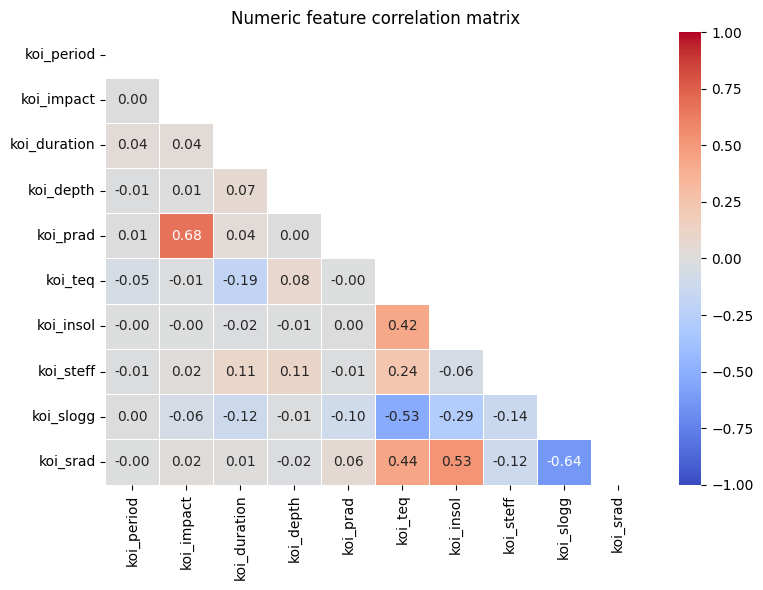

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# numeric correlation heatmap
num_cols = df1.select_dtypes(include=[np.number]).columns.tolist()
corr = df1[num_cols].corr()

plt.figure(figsize=(8,6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".2f", linewidths=.5)
plt.title('Numeric feature correlation matrix')
plt.tight_layout()
plt.show()


Stellar radius, stellar gravity, equilibrium temperature, and insolation are all expressing variations in star size and brightness. Only one amongst the four should be kept. Stellar radius seems to be the obvious choice. Temperature is anyways not a factor in determoining whether an object is a planet or not.

Transit parameters (koi_period, koi_duration, koi_depth) show near-zero correlation with each other. These carry independent information and should be kept.

Impact parameter controls the shape and depth of the transit light curve. It does not determine planet-ness. It only indicates how centrally the object crosses the star.
Planet classification in transit data depends on mass–radius inference and orbital clearing criteria. Impact parameter is used only to recover transit geometry, not classification.

In [15]:
df1 = df1.drop(columns=['koi_steff', 'koi_srad', 'koi_teq', 'koi_insol'], errors='ignore')

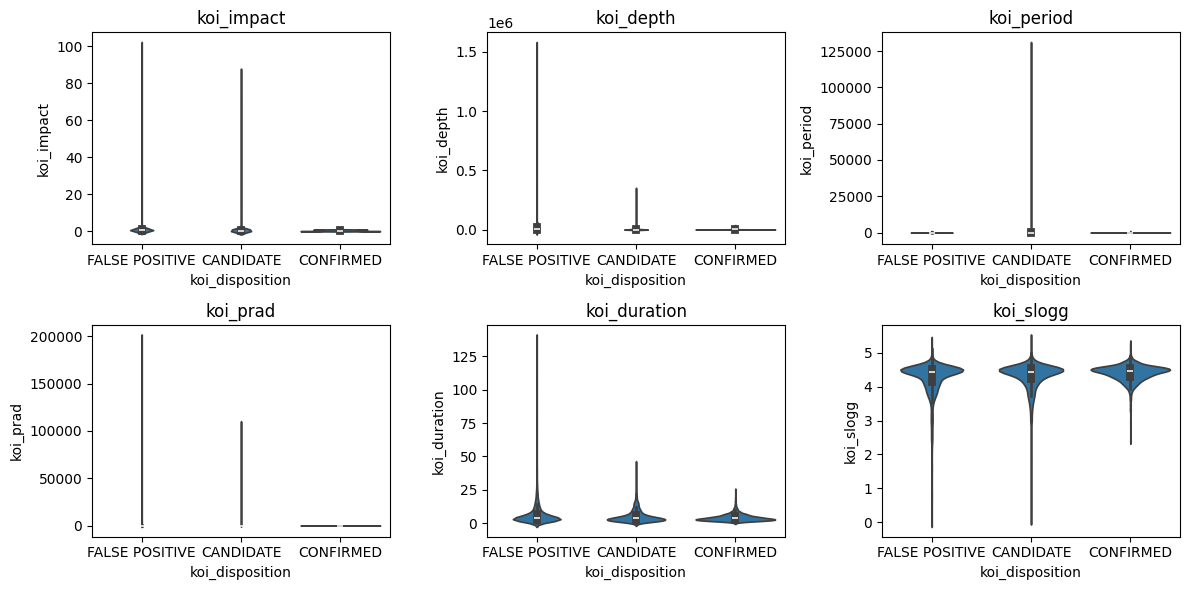

In [16]:
top_features = ['koi_impact','koi_depth','koi_period','koi_prad','koi_duration','koi_slogg']
exist = [f for f in top_features if f in df1.columns]
plt.figure(figsize=(12,6))
for i,f in enumerate(exist):
    plt.subplot(2, int(np.ceil(len(exist)/2)), i+1)
    sns.violinplot(x='koi_disposition', y=f, data=df1, order=['FALSE POSITIVE','CANDIDATE','CONFIRMED'])
    plt.title(f)
plt.tight_layout()
plt.show()


koi_impact:
Violin plots: heavy overlap across all three classes with extreme spread. No stable shift in median.
Correlation map: near-zero correlation with almost everything. Low signal, high noise.
Physics: impact parameter is set by viewing geometry. It does not diagnose planet vs eclipsing binary. Keep out.

koi_prad and koi_depth are correlated; tree models can keep both, linear models should regularize or drop one.
Other listed features show usable class separation; impact does not.

In [17]:
df1 = df1.drop('koi_impact', axis=1, errors='ignore')

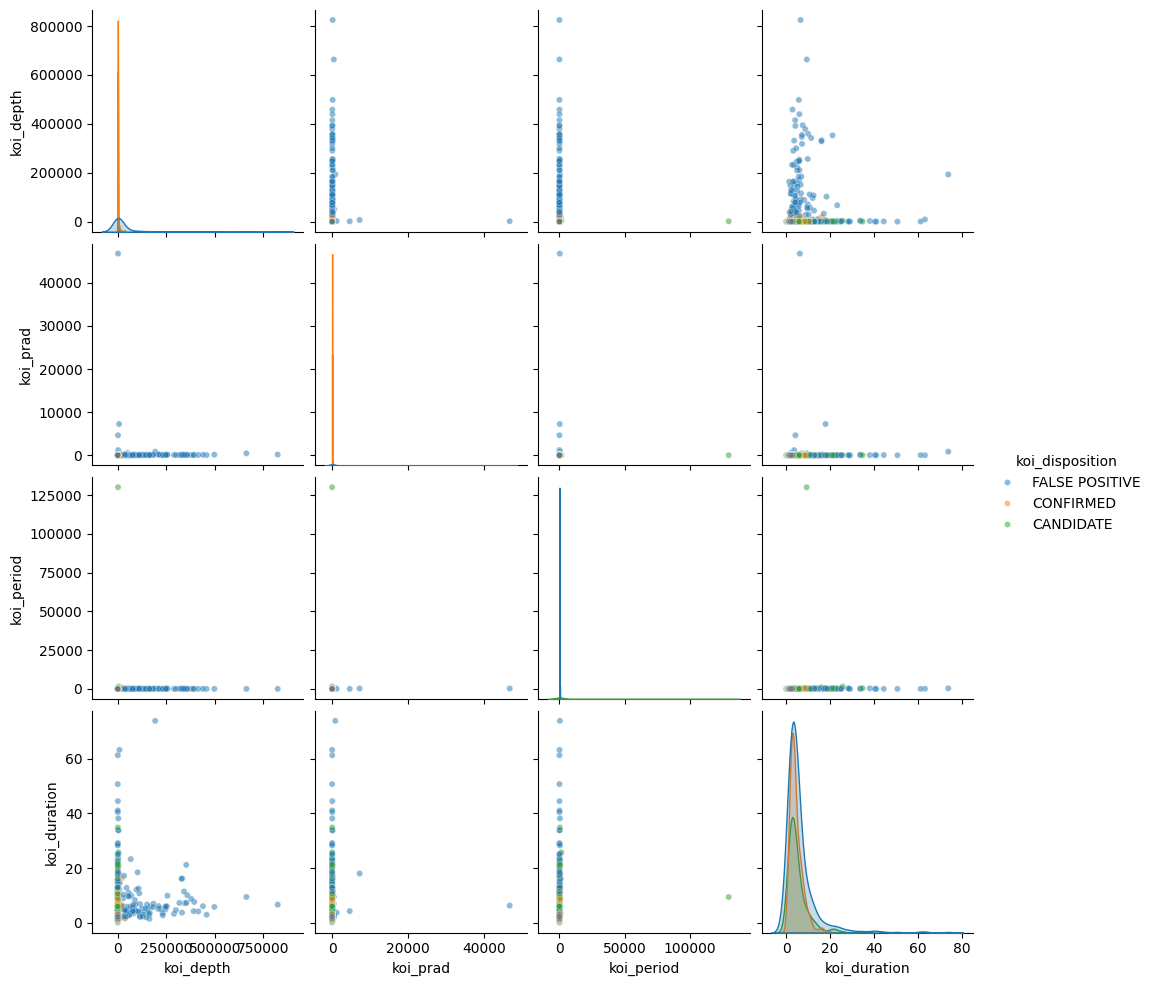

In [18]:
sample = df1.sample(n=1000, random_state=0)
cols = ['koi_depth','koi_prad','koi_period','koi_duration']
cols = [c for c in cols if c in sample.columns]
sns.pairplot(sample[cols + ['koi_disposition']], hue='koi_disposition', vars=cols, plot_kws={'alpha':0.5,'s':20})
plt.show()


False positives occupy the “extreme” regions. Confirmed planets cluster in the physically plausible region.

Direct observations from the pairplot:

1. koi_depth vs koi_prad: False positives dominate the very large depth and very large radius regime. Confirmed planets cluster at small-to-moderate depth and radius.This matches the physical expectation: eclipsing binary systems produce deeper and wider transits → flagged as false positives.

2. koi_depth vs koi_period and koi_prad vs koi_period: Period does not isolate classes alone; distributions overlap. But extreme long or extremely short periods appear more in false positives. So koi_period adds weak but supportive classification value.

3. koi_duration: Duration clusters for confirmed objects are relatively tight. False positives show longer tails and scattered outliers. Duration helps flag physically         inconsistent transit geometry.

Hence, koi_prad and koi_depth are essential - they carry the separation signal. koi_duration and koi_period are useful auxiliary features. Including koi_slogg (from earlier) improves classification by removing giant-star false positives.

In [20]:
df1.columns

Index(['koi_disposition', 'koi_period', 'koi_duration', 'koi_depth',
       'koi_prad', 'koi_slogg'],
      dtype='object')

Apply Kruskal–Wallis to check whether a feature’s distribution changes across class labels. If p is very small, that feature carries class-related signal. This supports including the feature in a classification model. If p is large, the feature does not separate groups and contributes little

In [21]:
import scipy.stats as st

features = ['koi_depth','koi_prad','koi_period','koi_duration','koi_slogg','koi_impact','koi_steff','koi_srad','koi_teq','koi_insol']
features = [f for f in features if f in df.columns]

for f in features:
    groups = [g[f].dropna().values for _, g in df.groupby('koi_disposition')]
    stat, p = st.kruskal(*groups)
    print(f, p)


koi_depth 3.434726264336258e-101
koi_prad 2.4006334910970527e-200
koi_period 2.8016719783117588e-120
koi_duration 1.4461429023791088e-22
koi_slogg 1.0902243248263751e-26
koi_impact 1.1338885468513811e-171
koi_steff 1.6287745166110192e-83
koi_srad 4.218391877148215e-33
koi_teq 2.196419571013264e-164
koi_insol 3.321707109393469e-168


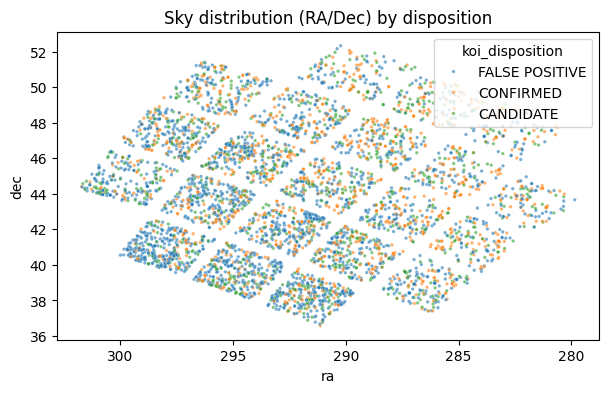

In [ ]:
if 'ra' in df.columns and 'dec' in df.columns:
    plt.figure(figsize=(7,4))
    sns.scatterplot(data=df.sample(5000, random_state=0), x='ra', y='dec', hue='koi_disposition', s=6, alpha=0.6)
    plt.title('Sky distribution (RA/Dec) by disposition')
    plt.gca().invert_xaxis()  # optional, RA convention
    plt.show()


No spatial separation. The RA/Dec scatter is uniform across disposition classes.
Sky position does not provide classification signal and should not be used as a feature.

FEATURE ENGINEERING

In [22]:
df1.columns

Index(['koi_disposition', 'koi_period', 'koi_duration', 'koi_depth',
       'koi_prad', 'koi_slogg'],
      dtype='object')

In [23]:
print(df.shape, df1.shape)

(9564, 49) (9564, 6)


In [24]:
df2 = df1.copy()

# Log transformations (reduce skewness for wide-value columns)
for col in ["koi_period", "koi_depth", "koi_duration"]:
    if col in df2.columns:
        df2[f"log_{col}"] = np.log1p(df2[col])

# Transit shape index — geometric indicator of transit type
if all(x in df2.columns for x in ["koi_depth", "koi_duration"]):
    df2["transit_shape_index"] = df2["koi_depth"] / df2["koi_duration"]


In [25]:
df2.head(5)

,koi_disposition,koi_period,koi_duration,koi_depth,koi_prad,koi_slogg,planet_star_radius_ratio,log_koi_period,log_koi_depth,log_koi_duration,transit_shape_index,scaled_prad,depth_x_duration,period_x_depth,depth_zscore
0,CONFIRMED,9.488036,2.95750,615.8,2.26,4.467,2.437972,2.350235,6.424545,1.375613,208.216399,2.236874,1821.228500,5842.732304,-0.281795
1,CONFIRMED,54.418383,4.50700,874.8,2.83,4.467,3.052859,4.014911,6.775138,1.706020,194.098070,2.801041,3942.723600,47605.201186,-0.278645
2,CANDIDATE,19.899140,1.78220,10829.0,14.60,4.544,16.820276,3.039708,9.290075,1.023242,6076.197958,14.448037,19299.443800,215487.786519,-0.157611
3,FALSE POSITIVE,1.736952,2.40641,8079.2,33.46,4.564,42.300885,1.006845,8.997172,1.225659,3357.366367,33.110210,19441.867672,14033.186258,-0.191046
4,CONFIRMED,2.525592,1.65450,603.3,2.75,4.438,2.629063,1.260048,6.404071,0.976256,364.641886,2.722041,998.159850,1523.689519,-0.281946


In [26]:
# 1. Basic distribution and spread of stellar radius
df['koi_srad'].describe()

count    9201.000000
mean        1.728712
std         6.127185
min         0.109000
25%         0.829000
50%         1.000000
75%         1.345000
max       229.908000
Name: koi_srad, dtype: float64

In [27]:
# 2. Coefficient of Variation (CV): lower CV → more reliable radius
cv_srad = df['koi_srad'].std() / df['koi_srad'].mean()
cv_srad

np.float64(3.5443649757816926)

In [29]:
df2.head(5)

,koi_disposition,koi_prad,koi_slogg,log_koi_period,log_koi_depth,log_koi_duration,transit_shape_index
0,CONFIRMED,2.26,4.467,2.350235,6.424545,1.375613,208.216399
1,CONFIRMED,2.83,4.467,4.014911,6.775138,1.706020,194.098070
2,CANDIDATE,14.60,4.544,3.039708,9.290075,1.023242,6076.197958
3,FALSE POSITIVE,33.46,4.564,1.006845,8.997172,1.225659,3357.366367
4,CONFIRMED,2.75,4.438,1.260048,6.404071,0.976256,364.641886


In [ ]:
dfA = df2[df2['koi_disposition'].isin(['CONFIRMED','FALSE POSITIVE'])].copy()
dfA['label'] = (dfA['koi_disposition'] == 'CONFIRMED').astype(int)

In [74]:
print(dfA.shape)
dfA.describe()

(7585, 8)


,koi_prad,koi_slogg,log_koi_period,log_koi_depth,log_koi_duration,transit_shape_index,label
count,7326.000000,7326.000000,7585.000000,7326.000000,7585.000000,7326.000000,7585.000000
mean,104.169379,4.310837,2.505221,6.901730,1.670158,5939.251885,0.362030
std,3180.483497,0.437200,1.607184,2.488265,0.613176,19584.374639,0.480619
min,0.080000,0.047000,0.216596,0.587787,0.099483,0.324942,0.000000
25%,1.500000,4.218000,1.176512,5.213032,1.245393,43.821688,0.000000
50%,2.620000,4.438000,2.205407,6.219596,1.576088,136.580579,0.000000
75%,24.185000,4.543000,3.451665,7.749344,1.983894,678.204345,1.000000
max,200346.000000,5.283000,6.977498,14.248202,4.938351,416154.501817,1.000000


4 columns contains 259 rows that have missing values => ~3.4%. Dropping them as it imputing with median may hinder in model learning 

In [ ]:
#drop rows with missing values
dfA_drop = dfA.dropna(axis=0).copy()
dfA_drop.shape

(7326, 8)

Splitting Dataset into Train-Test set. The Test Set contains only the two classes - positive class, Planet (confirmed) and negative class, Non-Planet (False Positives)

In [79]:
from sklearn.model_selection import train_test_split
X = dfA_drop.drop(['koi_disposition','label'], axis=1)
y = dfA_drop['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5860, 6) (5860,) (1466, 6) (1466,)


Testing RandomForest, XGBoost and LightGBM classifiers on the training set using Stratified 5 Fold CV so that class balance remains same in each of the folds. And performing hyperparameter tuning using GridSearch.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_pipe = Pipeline([
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=0))
])

rf_params = {
    'rf__n_estimators': [300, 400, 500],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [4, 5, 6],
    'rf__min_samples_leaf': [1, 2, 3],
    'rf__max_features': ['sqrt', 'log2', 0.6]
}

rf_gs = GridSearchCV(rf_pipe, rf_params, scoring='f1', cv=5, n_jobs=-1)
rf_gs.fit(X_train, y_train)

rf_best = rf_gs.best_estimator_

In [81]:
rf_gs.best_params_

{'rf__max_depth': None,
 'rf__max_features': 0.8,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 6,
 'rf__n_estimators': 300}

In [109]:
from xgboost import XGBClassifier

xgb_pipe = Pipeline([
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=(sum(y_train==0)/sum(y_train==1)),
        random_state=0
    ))
])

xgb_params = {
    'xgb__n_estimators':[200,400, 600, 800],
    'xgb__max_depth':[3,6,10],
    'xgb__learning_rate':[0.05,0.1]
}

xgb_gs = GridSearchCV(xgb_pipe, xgb_params, scoring='f1', cv=5, n_jobs=-1)
xgb_gs.fit(X_train, y_train)

xgb_best = xgb_gs.best_estimator_


In [107]:
from lightgbm import LGBMClassifier

lgb_pipe = Pipeline([
    ('lgb', LGBMClassifier(class_weight='balanced', random_state=0))
])

lgb_params = {
    'lgb__n_estimators':[200,400, 600, 800],
    'lgb__num_leaves':[31,63],
    'lgb__learning_rate':[0.05,0.1]
}

lgb_gs = GridSearchCV(lgb_pipe, lgb_params, scoring='f1', cv=5, n_jobs=-1)
lgb_gs.fit(X_train, y_train)

lgb_best = lgb_gs.best_estimator_

[LightGBM] [Info] Number of positive: 2195, number of negative: 3665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 5860, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Performing the Model Evaluation. Priority will be given to F1 for our purpose

In [110]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

models = {
    'RF': rf_best,
    'XGB': xgb_best,
    'LGB': lgb_best,
}

for name, m in models.items():
    y_pred = m.predict(X_test)
    print("\n=== {} ===".format(name))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3))


=== RF ===
[[820  97]
 [ 64 485]]
              precision    recall  f1-score   support

           0      0.928     0.894     0.911       917
           1      0.833     0.883     0.858       549

    accuracy                          0.890      1466
   macro avg      0.880     0.889     0.884      1466
weighted avg      0.892     0.890     0.891      1466


=== XGB ===
[[812 105]
 [ 58 491]]
              precision    recall  f1-score   support

           0      0.933     0.885     0.909       917
           1      0.824     0.894     0.858       549

    accuracy                          0.889      1466
   macro avg      0.879     0.890     0.883      1466
weighted avg      0.892     0.889     0.890      1466


=== LGB ===
[[809 108]
 [ 49 500]]
              precision    recall  f1-score   support

           0      0.943     0.882     0.912       917
           1      0.822     0.911     0.864       549

    accuracy                          0.893      1466
   macro avg      0.8

All three models have similar precision. The difference is recall. LGBM recovers more true planets (class 1) while still keeping false alarms controlled. This gives LGB the highest F1 score overall. Higher recall means more planets detected. Slightly lower precision means slightly more false positives than RF. Missing a real planet is usually worse than reviewing a few extra false positives.

1. RF has a moderate miss rate (64 real planets lost).
2. XGB trades precision for better recall of planets. It recovers more real planets at the cost of misclassifying slightly more false positives. 
3. LightGBM loses the fewest real planets. It chooses to allow a few more false alarms so that real planets are not missed.

Hence, LGBM is the final model to be selected.


In [ ]:
# rebuild dataset without the candidate class
dfA = df2[df2['koi_disposition'].isin(['CONFIRMED','FALSE POSITIVE'])].copy()
dfA['label'] = (dfA['koi_disposition'] == 'CONFIRMED').astype(int)

X_full = dfA.drop(['koi_disposition','label'], axis=1)
y_full = dfA['label']

# retrain the tuned model on all available labeled data
final_lgb = lgb_best
final_lgb.fit(X_full, y_full)

[LightGBM] [Info] Number of positive: 2746, number of negative: 4839
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 7585, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Pipeline(steps=[('lgb',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.05,
                                n_estimators=200, random_state=0))])

Predicting on Test Set

In [112]:
y_pred = final_lgb.predict(X_test)

print(f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

0.9242553191489362
[[834  83]
 [  6 543]]
              precision    recall  f1-score   support

           0      0.993     0.909     0.949       917
           1      0.867     0.989     0.924       549

    accuracy                          0.939      1466
   macro avg      0.930     0.949     0.937      1466
weighted avg      0.946     0.939     0.940      1466



Checking Feature Importance

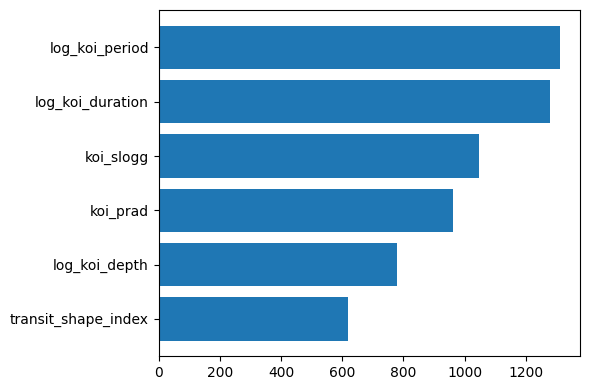

In [117]:
model = final_lgb.named_steps['lgb']
importances = model.feature_importances_
feature_names = X_full.columns

fi = pd.DataFrame({'feature':feature_names,'importance':importances})
fi = fi.sort_values('importance',ascending=False)

plt.figure(figsize=(6,4))
plt.barh(fi['feature'],fi['importance'])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

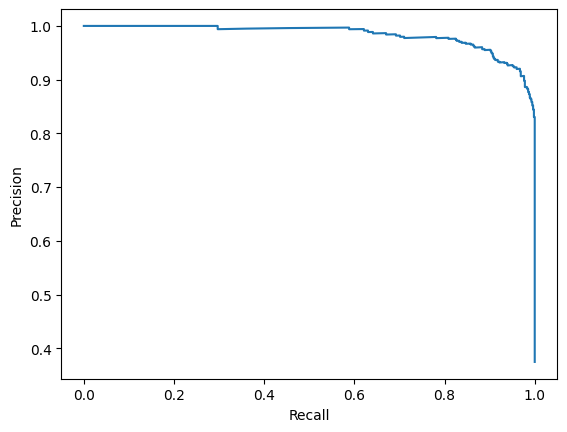

In [118]:
from sklearn.metrics import precision_recall_curve

probs = final_lgb.predict_proba(X_test)[:,1]
p,r,_ = precision_recall_curve(y_test, probs)
plt.plot(r,p)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

The PR curve stays near precision ≈ 1.0 through most recall range. This means the model retrieves many true planets before false positives begin to rise. The sharp drop only appears at very high recall where the model pushes threshold too low.

0.9910176726595199


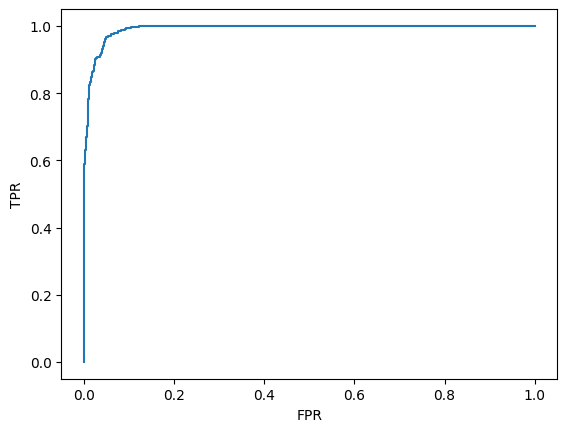

In [119]:
from sklearn.metrics import roc_curve, auc

fpr,tpr,_ = roc_curve(y_test, probs)
print(auc(fpr,tpr))
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

AUC ≈ 0.99 means the model ranks positives above negatives almost perfectly.

Both curves indicate the model separates classes cleanly.

Scoring probability scores for all CANDIDATE rows.

In [102]:
dfC = df2[df2['koi_disposition'] == 'CANDIDATE'].copy()
X_cand = dfC.drop(['koi_disposition'], axis=1)

In [103]:
dfC.shape

(1979, 7)

In [101]:
X_cand.shape

(1979, 6)

Score candidates - whether they are planet or not

In [121]:
dfC['planet_probability'] = final_lgb.predict_proba(X_cand)[:,1]
dfC_sorted = dfC.sort_values('planet_probability', ascending=False)

Sort candidates by probability and export to a CSV file

In [122]:
dfC_sorted.to_csv('ranked_candidates.csv', index=False)